# Stochastic model ideas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
%matplotlib inline

### coin game
A simple game of chance is played by flipping a coin. If the coin lands heads the player gets \\$1. If the coin lands tails the player loses \\$1. The player starts with \\$10.

- What are the odds the player goes broke before doubling their money?
- How long on average does a game last?

### SIR
Consider the SIR model

\begin{align*}
\frac{dS}{dt} &= m(S+I+R) -mS + \gamma R -\alpha SI  \\
\frac{dI}{dt} &= \alpha SI - \beta I - \nu I -mI\\
\frac{dR}{dt} &= \beta I - \gamma R - mR
\end{align*}



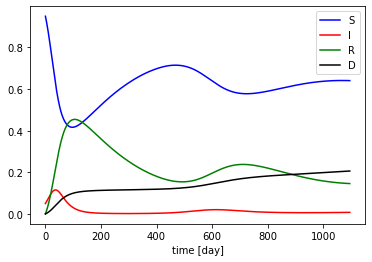

In [88]:
alpha = np.random.normal(loc=0.15,scale=0.05)
beta = 1./14.
nu = np.random.normal(loc=0.01,scale=0.003)
gamma = 1./300.
m = 7.5e-4

t = np.linspace(0,3*365,1001) #one year time period 
pop = 1000 #population size

def SIRmodel(t,y):
    S, I, R, D = y
    return ([m*(S+I+R) + gamma*R-alpha*S*I - m*S,alpha*S*I-beta*I-nu*I-m*I,beta*I-gamma*R-m*R, nu*I])

initinfected = 50.
Iinit = initinfected/pop
Sinit = (pop - initinfected)/pop 
Rinit = 0.
Dinit = 0.

sol = solve_ivp(SIRmodel,[t[0],t[-1]],[Sinit,Iinit,Rinit, Dinit],dense_output=True)

plt.plot(t,sol.sol(t)[0],'b',t,sol.sol(t)[1],'r',t,sol.sol(t)[2],'g',t,sol.sol(t)[3],'k');
plt.xlabel('time [day]');
plt.legend(['S','I','R','D']);



### Stochastic SIR
Consider the SIR model

\begin{align*}
\frac{dS}{dt} &= m(S+I+R) -\alpha SI  \\
\frac{dI}{dt} &= \alpha SI - \beta I - \nu I - mI \\
\frac{dR}{dt} &= \beta I -mR
\end{align*}

- Use the Gillespie algorithm to simulate this model for 1 year.
- Consider a situation where $m=0, \nu=0.01$. Run until infection is done and report the time. 

In [68]:
alpha = 0.05
beta = 0.09
nu = 0.01
m = 0.0e-4
def getprobs(state):
    #calculate probs of process transitions given state
    S,I,R = state[0],state[1],state[2]
    probs = np.zeros(7)
    probs[0] = m*(S+I+R) #birth
    probs[1] = m*S #S death
    probs[2] = m*I #I natural death
    probs[3] = m*R #recovered death
    probs[4] = alpha*S*I #infection
    probs[5] = beta*I #recovery
    probs[6] = nu*I #death due to infection
    return(probs)

def getprocess(probs):
    #determine which process from list of probs
    r = np.random.random()*np.sum(probs)
    process = 0
    s = probs[process]
    while (r > s):
        process += 1
        s += probs[process]
    return(process)
    
    

In [90]:
def getflutimes():

    #simulate SIR with gillespie once
    endtime = 365
    ntrans=0

    Sinit = 49
    Iinit = 1
    Rinit = 0
    S = Sinit
    I = Iinit
    R = Rinit
    time = 0.
    state = [Sinit, Iinit, Rinit]

    #result = np.array(state)
    times= np.array([time])
    Ss = np.array([Sinit])
    Is = np.array([Iinit])
    Rs = np.array([Rinit])

    while ((time < endtime) and (I > 0)):
        ntrans+=1

        state = [S, I, R]
        #get probs for transitions in current state
        probs = getprobs(state)
        #get time to transition
        tau = (1./np.sum(probs))*np.log(1./np.random.random())
        #update time
        time += tau
        times = np.append(times,time)
        #get which process happens
        process = getprocess(probs)
        #update state
        if (process == 0):
            S += 1
        if (process == 1):
            S -= 1
        if (process == 2):
            I-=1
        if (process == 3):
            R-=1
        if (process == 4):
            S-=1 
            I+=1
        if (process == 5):
            I-=1 
            R+=1
        if (process == 6):
            I-=1
        Ss = np.append(Ss,S)
        Is = np.append(Is,I)
        Rs = np.append(Rs,R)
        
    return(times[-1])



#print(ntrans)
#plt.plot(times,Ss,'b',times,Is,'r',times,Rs,'g');

58.25025466598014


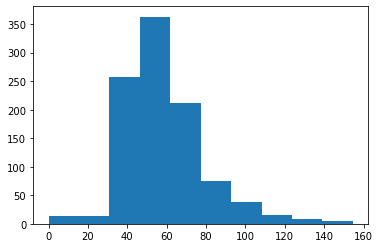

In [92]:
ntimes = 1000
flutimes = np.zeros(ntimes)
for i in range(0,ntimes):
    flutimes[i] = getflutimes()

plt.hist(flutimes)
print(np.mean(flutimes))